In [15]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
import os
import pandas as pd
import glob

In [61]:
# simulate and count how many times the good option/ bad option wins:
def sim_winner_count():
    global pis, qs, l, lci, N, maxTime, Nrea, ic, ci_kwargs
    pichain = ','.join([str(pi) for pi in pis])
    qchain = ','.join([str(q) for q in qs])
    ci_kwargs_chain = ','.join([str(cikw) for cikw in ci_kwargs])
    simCall = f'python LES_model_gill.py -pis {pichain} -qs {qchain} -l {l} -lci {lci} -ci_kwargs {ci_kwargs_chain} '
    simCall += f'-N {N} -maxTime {maxTime} -Nrea {Nrea} -ic {ic} > simEnds.txt'
    call(simCall, shell=True)
    df = pd.read_csv('simEnds.txt', sep='\s+', names=['f0', 'f1', 'f2'])
    f1wins = len(df.query('f1 > f2 & f1 > f0'))
    f2wins = len(df.query('f2 > f1 & f2 > f0'))
    f0wins = len(df.query('f0 > f1 & f0 > f2'))
    f1f2draw = len(df.query('f1 == f2'))
    return f0wins,f1wins,f2wins,f1f2draw
    

In [60]:
df = pd.read_csv('simEnds.txt', sep='\s+', names=['f0', 'f1', 'f2'])
f1wins = len(df.query('f1 > f2 & f1 > f0'))
f2wins = len(df.query('f2 > f1 & f2 > f0'))
f0wins = len(df.query('f0 > f1 & f0 > f2'))
f1f2draw = len(df.query('f1 == f2'))
print(f0wins,f1wins,f2wins,f1f2draw)

0 89 111 0


In [62]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
l, lci, N, maxTime, Nrea, ic = 0.6, 0.6, 250, 70.0, 200, 'N'

# changing x0: 
# ci_kwargs_list = [[1,], [2, 0.2, 40], [2, 0.35, 40], [2, 0.5, 40], [2, 0.8, 40]]
# changing a:
ci_kwargs_list = [[1,], [2, 0.35, 5], [2, 0.35, 10], [2, 0.35, 20], [2, 0.35, 40]]
fi_win_counts = {'f0':[], 'f1':[], 'f2':[], 'f1f2draw':[]}

for ci_kwargs in ci_kwargs_list:
    f0wins, f1wins, f2wins, f1f2draw = sim_winner_count()
    if f0wins+f1wins+f2wins+f1f2draw != Nrea:
        print('oju!')
    print(f'{ci_kwargs}: ', f0wins/Nrea*100, f1wins/Nrea*100, f2wins/Nrea*100)
    fi_win_counts['f0'].append(f0wins)
    fi_win_counts['f1'].append(f1wins)
    fi_win_counts['f2'].append(f2wins)
    fi_win_counts['f1f2draw'].append(f1f2draw)

[1]:  0.0 43.5 56.49999999999999
[2, 0.35, 5]:  0.0 9.5 90.5
[2, 0.35, 10]:  0.0 10.0 90.0
[2, 0.35, 20]:  0.0 8.5 91.5
[2, 0.35, 40]:  0.0 8.0 91.0


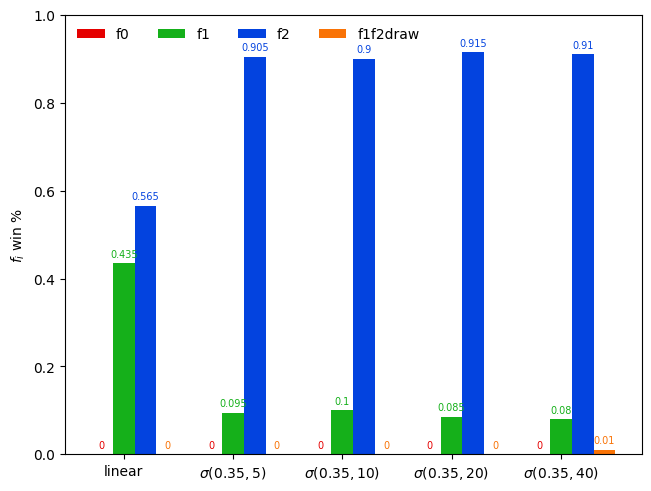

In [64]:
# shoud somehow label items of the ci_kwargs_list
# changing x0:
# species = ("linear", r"$\sigma(0.2,40)$", r"$\sigma(0.35,40)$", r"$\sigma(0.5,40)$", r"$\sigma(0.8,40)$")
# changing a:
species = ("linear", r"$\sigma(0.35,5)$", r"$\sigma(0.35,10)$", r"$\sigma(0.35,20)$", r"$\sigma(0.35,40)$")

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fi_colors = {'f0':'xkcd:red', 'f1':'xkcd:green', 'f2':'xkcd:blue', 'f1f2draw':'xkcd:orange'}
fig, ax = plt.subplots(layout='constrained')

for fi, wincount in fi_win_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, np.array(wincount)/Nrea, width, label=fi, color=fi_colors[fi])
    ax.bar_label(rects, padding=3, color=fi_colors[fi], fontsize=7)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$f_i$ win %')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=4, frameon=False)
ax.set_ylim(0, 1)

# fig.savefig(f'sim_dif_cimode_chx0_fi_win_perc_pi1_{pis[0]}_pi2_{pis[1]}_q1_{qs[0]}_q2_{qs[1]}_l_{l}_lci_{lci}_ic_{ic}.png')
fig.savefig(f'sim_dif_cimode_cha_fi_win_perc_pi1_{pis[0]}_pi2_{pis[1]}_q1_{qs[0]}_q2_{qs[1]}_l_{l}_lci_{lci}_ic_{ic}.png')